In [ ]:
! pip install pymystem3
! pip install pymorphy2
! pip install stanza

### Импорты

In [3]:
import pandas as pd
from nltk import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

# pos-taggers
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
import stanza

# evaluating results
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Создание и разметка корпуса

In [4]:
! git clone https://github.com/hemulitch/programming_3rd_year

Cloning into 'programming_3rd_year'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 111 (delta 5), reused 0 (delta 0), pack-reused 89
Receiving objects: 100% (111/111), 1.22 MiB | 3.21 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
with open('/content/programming_3rd_year/hw2/corpus.txt', 'r', encoding='utf-8') as f:
  corpus = f.readlines()

Я вручную собрала коллекцию предложений, каждое из которых может представлять интерес для pos-теггинга. Например:

In [ ]:
# предложения с омонимами - например, со словоформой стекло (NOUN/VERB)
print(corpus[0])
print(corpus[1])

Сапфировое стекло и корпус из желтого золота держит ремешок из крокодиловой кожи

Но с Крохина обидное прозвище стекло как с гуся вода.



In [ ]:
#предложения с именами собственными, которые могут быть интерпретированы как форма глагола/прилагательное
print(corpus[10])
print(corpus[14])
print(corpus[18])

И, само собой, продажи Дали не идут ни в какое сравнение с продажами Пикассо.

Приёмные комиссии были созданы в Горьком, Киеве, Ленинграде, Москве и Тбилиси. 

Настоящей жемчужиной в творчестве Мамина-Сибиряка стал роман «Приваловские миллионы».



In [ ]:
# предложения с аббревиатурами
print(corpus[16])
print(corpus[17])

Ольга отметилась во многих популярных сериалах 2000-х годов, таких как «Солдаты», «Моя прекрасная няня», «Ранетки», «Воронины», «Папины дочки». В последнем она сыграла роль Изольды Анатольевны, инспектора РОНО (в трех сериях).

Ряд учёных из Германии, Италии, Франции, Швеции, США, Китая, Кореи удостоены звания почётного профессора и доктора СПбГТИ (ТУ).



In [ ]:
# предложения с авторскими неологизмами, которых нет в словарях
print(corpus[13])

Нынче словом не пофанфороните – шею крючь да спину гни. На вершочном незаметном фронте завоёвываются дни.



In [ ]:
# разобьем каждый мини-текст в списке corpus на предложения
sentences = []
for text in corpus:
  sents = sent_tokenize(text)
  sentences += sents

In [ ]:
# заранее размеченный датасет
data = pd.read_csv('/content/programming_3rd_year/hw2/corpus.csv', delimiter=';')
data.head()

,token,tag
0,сапфировое,ADJ
1,стекло,NOUN
2,и,CONJ
3,корпус,NOUN
4,из,ADP


In [ ]:
# набор тегов в моей разметке
true_tags = data['tag'].values
print(" ".join(set(true_tags)))

NOUN CONJ INTJ NUM ADJ VERB ADV ADP PRON PART


При разметке я решила использовать набор тегов [universal pos tags](https://universaldependencies.org/u/pos/), поскольку он используется в большей части POS теггеров, упомянутых в задании, за исключением pymorphy и mystem. При этом мне было интересно сравнить возможности pymorphy и mystem с POS теггером, использующим universal pos теги, поэтому я внесла в набор тегов некоторые модификации, такие, чтобы было удобнее конвертировать результаты в единый формат, а именно:

- использовала тег CONJ вместо SCONJ и CCONJ для союзов, поскольку в pymorphy и mystem они не различаются
- не использовала тег AUX, поскольку в pymorphy и mystem AUX и VERB не различаются
- не использовала тег PROPN, поскольку в pymorphy и mystem нет отдельных тегов для имен собственных


### POS-теггеры

#### 1. pymorphy

In [ ]:
morph = MorphAnalyzer()

Pymorphy умеет обрабатывать только одно слово, не учитывая контекст, поэтому будем токенизировать предложение с помощью метода word_tokenize и искать часть речи для каждого получившегося токена:

In [ ]:
pymorphy_tokens = []
pymorphy_tags = []
for sentence in sentences:
  tokens = word_tokenize(sentence)
  for token in tokens:
    tag = morph.parse(token)[0].tag.POS
    pymorphy_tokens.append(token)
    pymorphy_tags.append(tag)

#### 2. Mystem


In [ ]:
mystem = Mystem()
mystem_tokens = []
mystem_tags = []
for sentence in sentences:
  ana = mystem.analyze(sentence)
  for token in ana:
    if 'analysis' in token:
        grammar = token['analysis'][0]['gr']
        tag = grammar.split('=')[0].split(',')[0]
        t = token['text']
        mystem_tokens.append(t)
        mystem_tags.append(tag)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


#### 3. Stanza

In [ ]:
stanza.download('ru')
nlp = stanza.Pipeline('ru')

INFO:stanza:Downloading default packages for language: ru (Russian) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| pos       | syntagrus_charlm   |
| lemma     | syntagrus_nocharlm |
| depparse  | syntagrus_charlm   |
| ner       | wikiner            |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
stanza_tokens = []
stanza_tags = []
for sentence in sentences:
  ana = nlp(sentence)
  tags = [[word.pos for word in sent.words] for sent in ana.sentences]
  tokens = [[word.text for word in sent.words] for sent in ana.sentences]
  for tag in tags:
    stanza_tags += tag
  for token in tokens:
    stanza_tokens += token

### Оценка результатов

После обработки результатов обнаружилось, что POS теггеры выдали набор тегов разной длины:

In [ ]:
print(f'Pymorphy: {len(pymorphy_tags)}')
print(f'Mystem: {len(mystem_tags)}')
print(f'Stanza: {len(stanza_tags)}')
print(f'Должно быть тегов: {len(true_tags)}')

Pymorphy: 502
Mystem: 400
Stanza: 504
Должно быть тегов: 398


Pymorphy попытался определить часть речи у пунктуации, поэтому в списке pymorphy_tags есть много объектов типа None:

In [ ]:
clean_pymorphy_tokens = []
clean_pymorphy_tags = []
for i in range(len(pymorphy_tags)):
    if pymorphy_tags[i] != None:
      clean_pymorphy_tags.append(pymorphy_tags[i])
      clean_pymorphy_tokens.append(pymorphy_tokens[i])

В Stanza для пунктуации встречаем тег PUNCT:

In [ ]:
clean_stanza_tokens = []
clean_stanza_tags = []
for i in range(len(stanza_tags)):
    if stanza_tags[i] != 'PUNCT':
      clean_stanza_tags.append(stanza_tags[i])
      clean_stanza_tokens.append(stanza_tokens[i])

После очистки списков от тегов для пунктуации длина списков всё равно была неодинакова, поэтому я написала функцию, позволяющую посмотреть, где разметка POS теггеров разошлась с моей разметкой:

In [ ]:
def differencies(tags, tokens, words):
  i = 0
  j = 0
  while i < len(tags):
    if words[j].lower() != tokens[i].lower():
      print(words[j], tokens[i], tags[i])
      if '2000' not in words[j]:
        i += 1
    i += 1
    j += 1

Stanza выделил два токена там, где я выделила один:

In [ ]:
words = data['token'].values
differencies(clean_stanza_tags, clean_stanza_tokens, words)

историко-архивные историко ADJ


In [ ]:
clean_stanza_tags.pop(183)
clean_stanza_tokens.pop(183)

'историко'

У Mystem-а была такая же ошибка, как у Stanza, и ещё другая ошибка: на месте одного токена (имени собственного - фамилии Мамин-Сибиряк) он выделил два токена (прилагательное мамин и существительное сибиряк)

In [ ]:
differencies(mystem_tags, mystem_tokens, words)

историко-архивные историко COM
2000-х х S
мамина-сибиряка Мамина A


In [ ]:
#mystem_tokens.index('историко')
mystem_tags.pop(183)
mystem_tokens.pop(183)

'историко'

In [ ]:
# mystem_tokens.index('Мамина')
mystem_tags.pop(382)
mystem_tokens.pop(382)

'Мамина'

После выравнивания результатов разметки мы применяем функцию, для конвертацию разметок в систему, которую использовала я при разметке датасета вручную:

In [ ]:
def convert_to_upos(tags):
  new_tags = []
  convert_dict = {
      'A': 'ADJ',
      'ADJF':'ADJ',
      'ADJS':'ADJ',
      'ADVB':'ADV',
      'ADVPRO': 'ADV',
      'ANUM': 'ADJ',
      'APRO': 'ADJ',
      'AUX' : 'VERB',
      'CCONJ': 'CONJ',
      'DET': 'ADJ',
      'GRND': 'VERB',
      'INFN': 'VERB',
      'NPRO': 'PRON',
      'NUMR': 'NUM',
      'PR': 'ADP',
      'PRCL': 'PART',
      'PREP': 'ADP',
      'PROPN': 'NOUN',
      'PRTF': 'VERB',
      'PRTS': 'VERB',
      'S': 'NOUN',
      'SCONJ': 'CONJ',
      'SPRO': 'PRON',
      'V': 'VERB'
      }
  upos_tags = ['ADJ', 'ADP', 'ADV', 'CONJ', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'VERB']

  for i in range(len(tags)):
    if tags[i] not in upos_tags:
      new_tags.append(convert_dict[tags[i]])
    else:
      new_tags.append(tags[i])

  return new_tags

In [ ]:
clean_pymorphy_tags = convert_to_upos([str(tag) for tag in clean_pymorphy_tags])

In [ ]:
mystem_tags = convert_to_upos(mystem_tags)
clean_stanza_tags = convert_to_upos(clean_stanza_tags)

Далее посмотрим на accuracy для различных POS теггеров

In [ ]:
print("Pymorphy, accuracy: %.4f" % accuracy_score(clean_pymorphy_tags, true_tags))
print("Mystem, accuracy: %.4f" % accuracy_score(mystem_tags, true_tags))
print("Stanza, accuracy: %.4f" % accuracy_score(clean_stanza_tags, true_tags))

Pymorphy, accuracy: 0.9070
Mystem, accuracy: 0.9372
Stanza, accuracy: 0.9422


И на матрицы ошибок:

In [ ]:
def make_confusion_matrix(true_tags, predicted_tags, name):
  cm = confusion_matrix(true_tags, predicted_tags)
  thresh = cm.max() / 2.

  fig, ax = plt.subplots(figsize=(7,7))

  im = ax.imshow(cm, cmap='RdPu')
  cbar = ax.figure.colorbar(im, ax=ax)
  cbar.ax.set_ylabel("count of predictions", rotation=-90, va="bottom")
  ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
  ax.set_xticks(np.arange(cm.shape[1]))
  ax.set_yticks(np.arange(cm.shape[0]))
  ax.set_xticklabels(set(true_tags))
  ax.set_yticklabels(set(true_tags))
  ax.set_xlabel('Predicted POS-tags')
  ax.set_ylabel('True POS-tags')
  ax.set_title(f'Confusion matrix: {name}', pad=50)

  texts = []
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      text = im.axes.text(j, i, format(cm[i, j], "d"), horizontalalignment="center",
                                  color="white" if cm[i, j] > thresh else "black")
      texts.append(text)

  fig.tight_layout()
  plt.show()

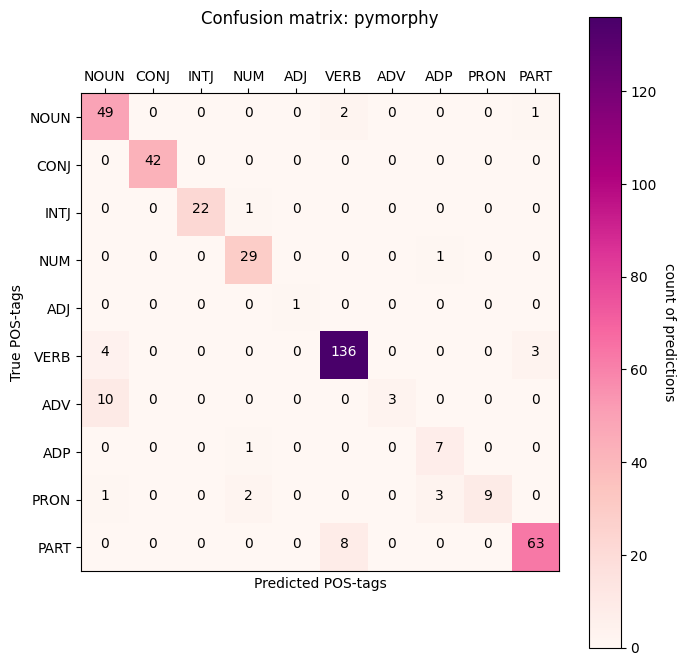

In [ ]:
make_confusion_matrix(true_tags, clean_pymorphy_tags, 'pymorphy')

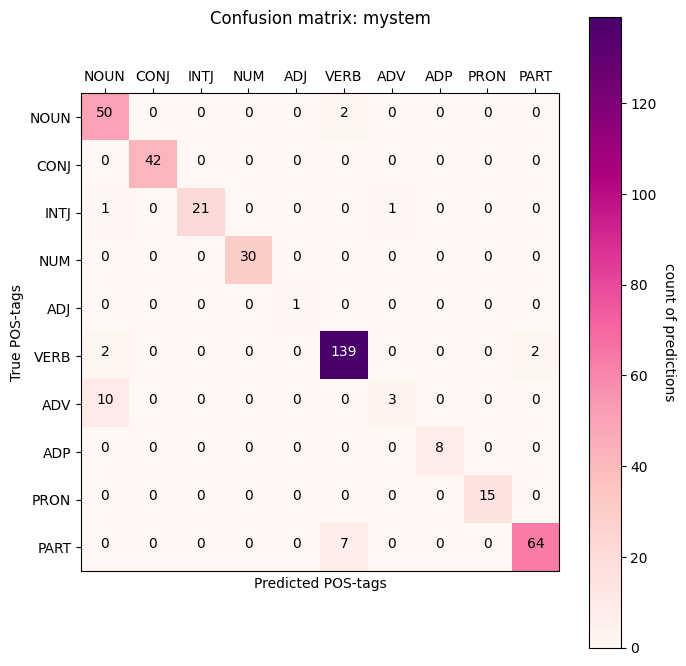

In [ ]:
make_confusion_matrix(true_tags, mystem_tags, 'mystem')

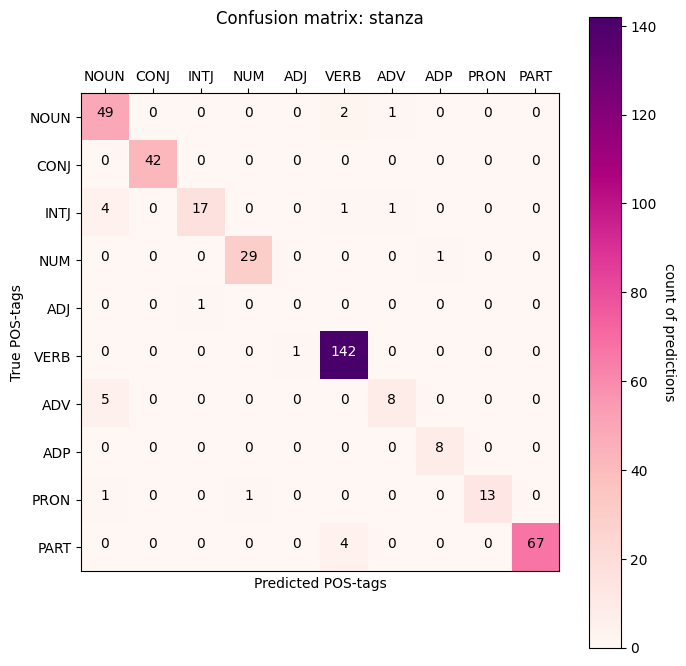

In [ ]:
make_confusion_matrix(true_tags, clean_stanza_tags, 'stanza')

Вывод: все POS теггеры хорошо справились, но лучше всего себя показал POS теггер stanza. Его будем использовать для создания chunker-a

### Chunker

Возьмем отзывы из предыдущей ДЗ

In [7]:
reviews = pd.read_csv('/content/programming_3rd_year/hw2/corpus_reviews.csv', delimiter=',')
reviews = reviews.drop(['Unnamed: 0'], axis=1)
reviews.head()

,Класс,Текст
0,1,я хотела бы поделиться своим отзывом о тональн...
1,1,давно искала идеальный тональный крем фирму вы...
2,1,о данном тональном креме я узнала пару месяцев...
3,1,всем привет до этого тонального крема с брендо...
4,1,ни для кого не секрет что комби кожа и жирная ...


In [8]:
positive_reviews = reviews[reviews['Класс'] == 1]
negative_reviews = reviews[reviews['Класс'] == 0]

Разметим их с помощью stanza

In [ ]:
stanza.download('ru')
nlp = stanza.Pipeline('ru')

In [10]:
def pos_tagging(reviews):
  pos_tagged_list = []
  for review in reviews:
    ana = nlp(review)
    for i in range(len(ana.sentences[0].words)):
      pos = ana.sentences[0].words[i].pos
      lemma = ana.sentences[0].words[i].lemma
      pos_tagged_list.append((lemma, pos))

  return pos_tagged_list

In [11]:
pos_tagged_reviews = pos_tagging(positive_reviews['Текст'].values[:5]) # возьмем часть отзывов

Далее напишем функцию, которая по определенным шаблонам вытаскивает n-граммы из текста

In [12]:
def chunker(patterns, text):
  ngrams = []
  for pattern in patterns:
      i = 0
      while i < len(text):
          j = i
          k = 0
          while k < len(pattern) and j < len(text):
            if pattern[k] == text[j][1] or pattern[k] == text[j][0]:
              k += 1
              j += 1
            else:
              break
          if k == len(pattern):
            ngram = [word for word, _ in text[i:j]]
            ngrams.append(ngram)
          i += 1
  return ngrams

В качестве шаблонов н-грамм я выбрала следующие сочетания:

- существительное + наречие + прилагательное: позволяет посмотреть характеристику некоторого объекта, которую дает автор отзыва; в этих триграммах в качестве наречия обычно выступают наречия степени, подчеркивающие степень выраженности этой положительной (очень приятный, очень удобный) или негативной (очень неудобный, слишком плотный) характеристики

- не + глагол + существительное: позволяет посмотреть на то, как автор отзыва описывает тональный крем в духе "не подчеркивает шелушения" (положительный отзыв)/"не перекрывает высыпания" (отрицательный отзыв); такие триграммы достаточно часто встречаются в текстах этих отзывов, и при одних и тех же существительных используются различные глаголы в зависимости от тональности отзыва

- глагол + наречие: эта биграмма дает характеристику некоторым свойствам тонального крема; отличия негативного отзыва от положительного зачастую проявляются в наречии, например, "перекрывает хорошо"/"перекрывает плохо" или "выглядеть хорошо"/"выглядеть ужасно"


In [54]:
patterns = [
    ['NOUN', 'ADV', 'ADJ'],
    ['не', 'VERB', 'NOUN'],
    ['VERB', 'ADV']
]

In [55]:
chunker(patterns, pos_tagged_reviews)

[['крем', 'очень', 'приятный'],
 ['горлышко', 'совсем', 'узенький'],
 ['макияж', 'очень', 'легкий'],
 ['размер', 'вполне', 'удобный'],
 ['плотность', 'чуть', 'суховатый'],
 ['спонжа', 'более', 'тонкий'],
 ['нос', 'иногда', 'тональный'],
 ['степень', 'больше', 'полезный'],
 ['не', 'подчеркнуть', 'пора'],
 ['не', 'наносить', 'крем'],
 ['не', 'ополаскивать', 'лицо'],
 ['не', 'полосить', 'сухость'],
 ['не', 'забивать', 'пора'],
 ['не', 'подчеркивать', 'шелушинка'],
 ['стать', 'значительно'],
 ['прийти', 'быстро'],
 ['хвалить', 'вдобавок'],
 ['набить', 'очень'],
 ['попасться', 'совсем'],
 ['закрываться', 'легко'],
 ['открываться', 'уже'],
 ['стоить', 'стойко'],
 ['работать', 'отлично'],
 ['нанести', 'сначала'],
 ['ощущать', 'легко'],
 ['сойти', 'локально'],
 ['сходить', 'локально'],
 ['мочь', 'слегка'],
 ['быть', 'много'],
 ['быть', 'предостаточно'],
 ['становиться', 'более'],
 ['наносить', 'хорошо'],
 ['иметь', 'слегка'],
 ['представить', 'совсем'],
 ['выбирать', 'более'],
 ['корректироват

Далее посмотрим на то, какие н-граммы встречаются в негативных отзывах

In [49]:
neg_tagged_reviews = pos_tagging(negative_reviews['Текст'].values[:5]) # возьмем часть отзывов

In [56]:
chunker(patterns, neg_tagged_reviews)

[['масло', 'очень', 'ощутимый'],
 ['флакон', 'вполне', 'удобный'],
 ['цвет', 'очень', 'светлый'],
 ['состояние', 'сейчас', 'нормальный'],
 ['тон', 'очень', 'заметный'],
 ['случай', 'очень', 'легкий'],
 ['крем', 'очень', 'неудобный'],
 ['не', 'спасать', 'ситуация'],
 ['не', 'маскировать', 'недостаток'],
 ['не', 'нравиться', 'ощущение'],
 ['не', 'вызывать', 'раздражение'],
 ['не', 'ложиться', 'маска'],
 ['провести', 'легонько'],
 ['быть', 'куда'],
 ['мочь', 'спокойно'],
 ['знать', 'рано'],
 ['покупать', 'типо'],
 ['наносить', 'конечно'],
 ['виглядеть', 'более'],
 ['купить', 'еще'],
 ['пролежать', 'практически'],
 ['показать', 'почему'],
 ['выглядеть', 'свежо'],
 ['распределять', 'равномерно'],
 ['густеть', 'качественно'],
 ['смотреться', 'ужасно'],
 ['хотеться', 'скоро'],
 ['выглядеть', 'еще'],
 ['нет', 'вроде'],
 ['загореть', 'поэтому'],
 ['смотреться', 'очень'],
 ['набирать', 'слишком'],
 ['иметь', 'более'],
 ['выбрать', 'темный'],
 ['ошибиться', 'надо'],
 ['брать', 'светлый'],
 ['удов

Таким образом, мы видим, что даже по одним и тем же шаблонам в положительных и негативных отзывах встречаются разные н-граммы, коррелирующие с тональностью отзыва. При бОльшем количестве размеченных отзывов и при подключении подсчета частотности н-грамм можно получить хорошее качество работы алгоритма